# Subclassing pySIMTRA objects

This guide explains how subclassing pySIMTRA objects allows for further customization of the simulation model to better match your specific sputter system. By subclassing, you can extend the functionality of pre-defined objects, such as `Magnetron` or `SputterSystem`, to introduce additional parameters or streamline configurations.

Throughout this guide, we will use the same multi-cathode sputter system described in the `Define a multi-cathode System` guide. However, instead of directly defining the system, we will wrap it in a custom class to introduce additional model parameters, such as deposition rates. Specifically, we will define a CustomSputterSystem class, which will also include a CustomMagnetron class. This subclassed CustomMagnetron will encapsulate constant model parameters, exposing only those parameters that need frequent adjustment for convenience.

Additionally, this guide demonstrates how to define a custom deposition function that processes the particle distributions returned by SIMTRA to combine them to compositions. 

Before proceeding, ensure that the necessary packages are installed. This guide also requires the mendeleev package (see the documentation [here] (https://mendeleev.readthedocs.io)), which will be used to retrieve the density and atomic mass of the deposited elements.ion.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mendeleev import element as Element  # needed to get the density and atomic mass for an element
import pysimtra as ps

# Import the classes which are later subclassed (just for type hinting)
from pysimtra import Magnetron, SputterSystem

Identical to the previous guides, make sure the SIMTRA executable was assigned to the package (this code only needs to be called once):

In [2]:
# Define the path to the SIMTRA application folder
sim_path = 'C:/Users/Felix/Desktop/simtra_v2.2'
# Import the application into the package
ps.import_exe(sim_path)

## Define a custom magnetron

First, we define a custom magnetron class, which is particularly useful in sputter systems with multiple identical cathodes. By encapsulating constant parameters within the class, we can expose only frequently adjusted parameters, making the system configuration more convenient and streamlined.

In this example, we assume the cathode tilt can be adjusted via a screw, as described in the paper. To enhance reusability, the position parameter is also exposed, allowing the same class to be used for all four cathodes in the system. Since all other parameters remain constant, they do not need to be included in the initializer.

Additionally, we automatically determine the racetrack file based on the defined sputtered element. When replicating this example, ensure that the file path is correctly set and that the referenced file exists in your local setup. For simplicity, we have not included full error handling for input validation in this tutorial.

In [3]:
# Define the custom magnetron, subclass the original pySIMTRA class
class CustomMagnetron(Magnetron):

    def __init__(self, name: str, cat_pos: float, tilt: float, elem: str = None, n_particles: int = 10 ** 8):

        """
        Class for a custom magnetron. The class defines a magnetron object based on a reduced number of parameters, e.g. the 
        racetrack path is generated from the element.
        
        :param name: name of the magnetron (ideally in camelCase)
        :param cat_pos: cathode position (in °) on the "anker circle"
        :param tilt: cathode tilt (in °)
        :param elem: element to be sputtered
        :param n_particles: number of particles to simulation, defaults to 10**8
        """

        # Construct the magnetron from circles, cones and cylinders
        target = ps.Circle(name='target', radius=0.0191, position=(0, 0, 0.055))
        shield = ps.Cone(name='shield', small_rho=0.0191, big_rho=0.023, height=0.005, position=(0, 0, 0.055))
        cap = ps.Circle(name='cap', radius=0.03, position=(0, 0, 0.06))
        cap.perforate(by='circle', radius=0.023)
        body = ps.Cylinder(name='body', radius=0.03, height=0.06)
        # Define the anker radius (identical to the multi-cathode guide)
        r_anker = 0.06
        # Calculate the position (in m) and orientation (in °)
        pos = np.cos(np.radians(cat_pos)) * r_anker, np.sin(np.radians(cat_pos)) * r_anker, 0
        orien = cat_pos, -tilt, 0
        # Create the dummy object from the surfaces
        m_object = ps.DummyObject(name=name, surfaces=[target, shield, cap, body], position=pos, orientation=orien)
        # Define a path to the racetrack file
        r_path = 'racetracks/%s_racetrack_1.5_inch.txt' % elem 
        # Construct the class by calling the superclass
        super().__init__(transported_element=elem, m_object=m_object, n_particles=n_particles, sputter_surface_index=1, 
                         racetrack_file_path=r_path)

## Define a custom sputter system

After defining the custom magnetron, we proceed with the custom sputter system class, which internally utilizes the `CustomMagnetron` class. In this example, we assume that cathode tilt and chamber pressure are frequently adjusted parameters, so we expose them to the outer scope for easier modification.

To enhance usability, we define the pressure input in mTorr, as this is a common unit in sputtering applications. Internally, the value is automatically converted to SI units (Pa). Similarly, since the cathode tilt is adjusted using a screw, we expose the scale reading as an input and internally convert it to a tilt angle (°). Additionally, the assignment of target elements to cathodes is handled via a dictionary, where the target number serves as keys.

We also define a custom function `sim_deposition` to start the simulation. In addition to specifying the voltage of the power supplies, which determines the maximum ion energy in the Thompson distribution, this function requires a dictionary of deposition rates as an input. The deposition rates are used to post-process the particle distribution simulated by SIMTRA, converting it into a final composition based on atomic mass and density, as described in the publication.ion.

In [4]:
class CustomSputterSystem(SputterSystem):

    def __init__(self, elements: dict[int, str], output_path: str, tilt: float = 20, pressure: float = 3.7, n_particles: int = 10 ** 8):

        """
        Creates a custom four-cathode sputter system.

        :param elements: materials in the sputtering chamber given by the cathode number (beginning at 1) and the element symbol name
        :param output_path: path at which the simulation results will be stored
        :param tilt: cathode tilt in mm as visible on the screws, defaults to 20 mm which equals 10°
        :param pressure: pressure in mTorr used for sputtering, defaults to 3.7 mTorr
        :param n_particles: number of particles to simulate, defaults to 10**8
        """

        # Create a cylindrical sputter chamber, convert from Pa to mTorr
        chamber = ps.Chamber.cylindrical(radius=0.12, length=0.18, temperature=293.15, pressure=0.13332 * pressure)
        # The chamber will have four cathodes positioned on an "anker circle" and with an identical tilt
        cat_pos = {1: 45, 2: 135, 3: -135, 4: -45}  # °
        # Convert the tilt on the adjustment screw to actual cathode tilt
        t_deg = tilt / 2  # °
        # Create a magnetron for each element
        mags: list[ps.Magnetron] = []
        for i, pos in cat_pos.items():
            # Create the custom magnetron
            mag = CustomMagnetron('mag%d' % i, pos, t_deg, elements[i], n_particles)
            mags.append(mag)
        # Define the substrate which also will be the same for all depositions
        s_surf = ps.Rectangle(name='subSurface', dx=0.05, dy=0.05, save_avg_data=True, avg_grid=(21, 21))
        substrate = ps.DummyObject(name='substrate', surfaces=[s_surf], position=(0, 0, 0.15))
        # Initialize the superclass
        super().__init__(chamber, mags, substrate, output_path)

    # Custom method for starting a deposition
    def sim_deposition(self, voltages: dict[int, float], dep_rates: dict[int, float]) -> pd.DataFrame:

        """
        Initiates the simulation of the deposition and converts the simulation results to composition.

        :param voltages: voltages of the power supplies which will be used maximum ion energies for the Thompson distribution
        :param dep_rates: measured deposition rates in the center of the substrate
        :return: DataFrame with the compositions in atomic percent
        """

        # Set the voltages on the power supplies as maximum ion energies
        elements: list[str] = []
        for i, v in voltages.items():
            # Find the magnetron with the respective name and set the maximum ion energy
            mag = [m for m in self.magnetrons if m.name == 'mag%d' % i][0]
            mag.max_ion_energy = v
            # Store the deposited element again for later generating the composition
            elements.append(mag.transported_element)
        # Call the simulate function in the superclass
        sim_res = self.simulate(['mag%d' % i for i in voltages.keys()])
        # Get the number of particles for every magnetron and flatten the result
        n_particles = {i: res.n_particles['substrate'].flatten() for i, res in zip(voltages.keys(), sim_res)}
        # Wrap the results in a pandas DataFrame
        n_particles = pd.DataFrame.from_dict(n_particles)
        n_particles.index = range(1, 442)
        # Convert to a deposition profile by normalizing to the center area and multiplying with the deposition rates
        dep_profile = n_particles / n_particles.loc[221] * pd.Series(dep_rates)
        # Change the column names to the elements
        dep_profile.rename(columns={i: e for i, e in zip(voltages.keys(), elements)}, inplace=True)
        # Calculate the ratio to arrive at the composition in volume percent
        vol = dep_profile.div(dep_profile.sum(axis=1), axis=0) * 100
        # Get the density and the atomic of each element via mendeleev
        density = pd.Series({e: Element(e).density for e in elements})
        at_mass = pd.Series({e: Element(e).mass for e in elements})
        # Convert the composition to atomic percent and return it
        return (density * vol / at_mass).div((density * vol / at_mass).sum(axis=1), axis=0) * 100

## Run the simulation

Here we assign the elements to the four cathodes and also specify the voltages and deposition rates. The latter will be used to convert the simulated particle distributions to compositions, similar to how it was done in the paper.

In [5]:
# Define the elements
elements = {1: 'Ni', 2: 'Pd', 3: 'Pt', 4: 'Ru'}
# Define the voltages on the power supplies for every magnetron
voltages = {1: 200, 2: 250, 3: 190, 4: 180}  # V
# Define the deposition rates, for this example we assume that the deposition rates are independent on the angle
dep_rates = {1: 0.04, 2: 0.15, 3: 0.1, 4: 0.05}  # nm/s
# Define an output path for the simulation
output_path = 'C:/Users/Felix/Desktop/sim_result'

# Define the sputter system, the simulation time can be adjusted by changing the number of simulated particles
system = CustomSputterSystem(elements, output_path, tilt=20, n_particles=10**8)
# Run the deposition simulation and retrieve the composition
composition = system.sim_deposition(voltages, dep_rates)

## Plot the results

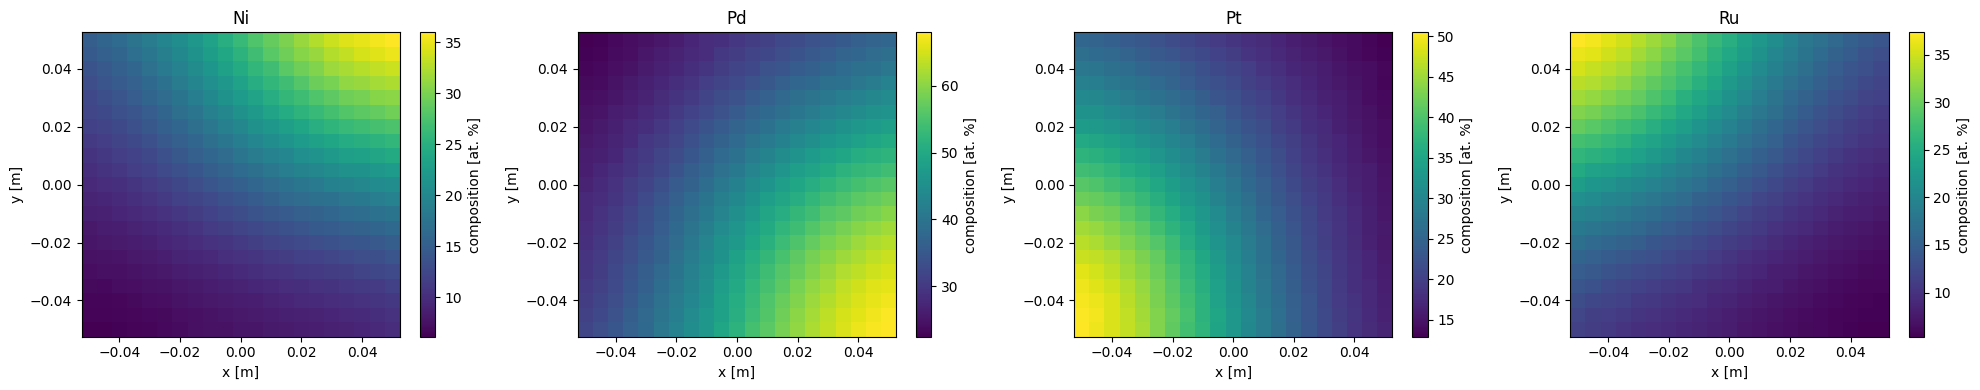

In [6]:
# Create a plot with as many subplots as there are elements
fig, ax = plt.subplots(1, len(elements), figsize=(len(elements) * 5, 4))

# Iterate over the elements and load plot the composition
for i, elem in enumerate(elements.values()):
    # Get the composition and reshape it to the original grid (the values are originating from the definition of the substrate in the
    # custom sputter system class
    xy = np.linspace(-0.05, 0.05, 21)
    X, Y = np.meshgrid(xy, xy)
    comp = composition[elem].values.reshape(X.shape)
    # Plot the composition
    pc = ax[i].pcolormesh(X, Y, comp)
    # Add axes labels
    ax[i].set_xlabel('x [m]')
    ax[i].set_ylabel('y [m]')
    # Add a title showing the sputtered element
    ax[i].set_title(elem)
    # Add a colorbar
    fig.colorbar(pc, ax=ax[i], label='composition [at. %]')

# Adjust layout and show the plot
fig.tight_layout()
plt.show()